# Transfer Learning + Back Prop: use images to predict valence.


*Yiyu Wang 2022/08*

Understanding how spatial features of an image contributes to predicting valence (pleasant, unpleasant) using transfer learning and back prop

1. Transfer learning: use pre-trained resNet to predict valence as a five-way classification (valence was rated 1-5 from negative to positive)
2. Back prop: use pixel as parameters and train a linear layer to identify pixels with pre-trained model weights that drives up the prediction of valence



Inspirations from Deep Dream:
A quick intro here:
https://ai.plainenglish.io/deepdream-ebe2a8016b29


"doing gradient ascent on the input to the convnet so as to maximize the activation of a selected filter in an upper layer of the convnet" 


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy
import glob
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, labels,paths, transform=None, target_transform=None):
        self.img_labels = labels
        self.img_paths = paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        image = image/255
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Dataset background:

In the real experiment, participants were shown many short clips, and then rated valence on a 1-5 likert scale in the fMRI.

Each frame of the videos were saved as a jpg, which is the training data for the pre-trained model to predict the valence rating associated with the video.

For demo purpose, this is done on only one participant, and only predict on negative valence (rating 1 as a category)

In [3]:

list_of_file_names = glob.glob('/work/abslab/BBOE/VideoInformation/SummaryFrames/*/*/*_18.9.jpg')
#pars =['001','002','003','005','006']
pars = ['005']
for par in pars:
    par_list_dfs =[]
    par_files = glob.glob(f'/work/abslab/BBOE/Behavioral/Participant_{par}/*/NSFScannerTask*')
    for par_file in par_files:
        par_list_dfs.append(pd.read_csv(par_file,delim_whitespace=True))
    par_df = pd.concat(par_list_dfs)

In [4]:
par_df['video_lower']=[str.lower(video_str.split('_')[0].split('.')[0]) for video_str in par_df.video]
img_names_list = [str.lower(img_str.split('/')[-1].split('_')[0]) for img_str in list_of_file_names]

img_path = []
for vid in par_df['video_lower']:
    try:
        img_path.append(list_of_file_names[img_names_list.index(vid)])
    except:
        img_path.append('vid missing')
par_df['image_paths']=img_path
val_image_df = par_df[['valence_rating','image_paths']][par_df.image_paths!='vid missing']

In [5]:
X_train,X_test,y_train,y_test = train_test_split(val_image_df.image_paths.values,
                                                 val_image_df.valence_rating.values,test_size=.33)

## A quick visual check on the data:
### display a random sample of frames, with valence rating printed on the top

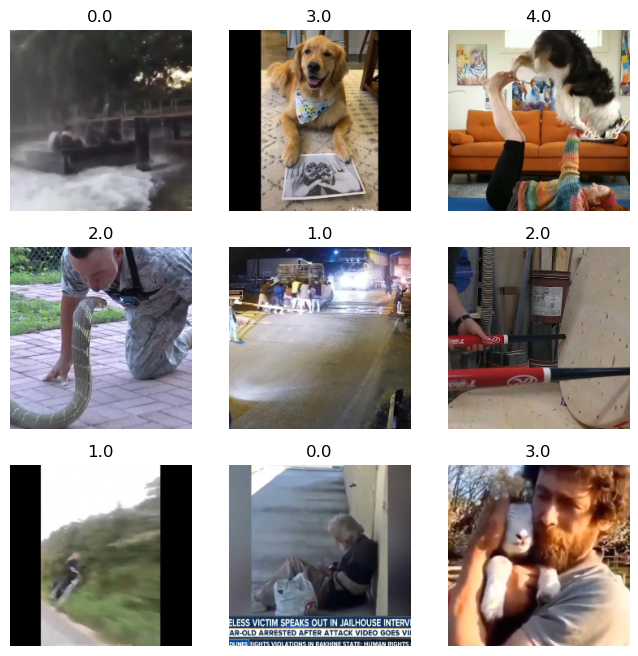

In [6]:
train_dataset = CustomImageDataset(y_train,X_train,
                             transform=transforms.Compose([
        transforms.Resize(256),transforms.CenterCrop(224)]))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()

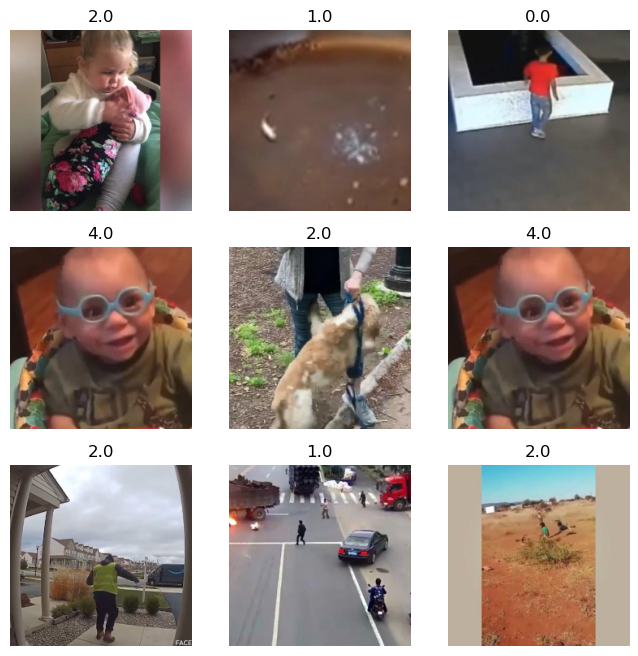

In [7]:
test_dataset = CustomImageDataset(y_test,X_test,
                             transform=transforms.Compose([
        transforms.Resize(256),transforms.CenterCrop(224)]))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()

### load resnet18 from torchvision:

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

/work/abslab/Yiyu/DNN_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/abslab/Yiyu/DNN_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### training the last linear layer to predict valence from the input image:


In [9]:
dataloader = DataLoader(train_dataset,batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

num_epochs =10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.SGD(model_ft.parameters(),lr=1e-5)
criterion = nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    

    # Iterate over data.
    for inputs, labels in dataloader:
        running_loss = 0.0
        running_corrects = 0
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels.long())

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    

        epoch_loss = running_loss / len(labels)
        epoch_acc = running_corrects.double() / len(labels)

        print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    
    
    model_ft.eval()
    test_inputs, test_labels = next(iter(test_dataloader))
    test_outputs = model_ft(test_inputs)   
    _, test_preds = torch.max(test_outputs, 1)
    
    
    test_loss = criterion(test_outputs, test_labels.long())
    test_corrects = torch.sum(test_preds == test_labels.data).double() / len(test_labels)

    test_epoch_loss = test_loss / len(test_labels)
    
    print(f' Testing Loss: {test_epoch_loss:.4f} Testing Acc: {test_corrects:.4f}')

Epoch 0/9
----------
 Loss: 1.7015 Acc: 0.2500
 Loss: 1.6806 Acc: 0.2188
 Loss: 1.7618 Acc: 0.1562
 Loss: 1.8657 Acc: 0.0938
 Loss: 1.7697 Acc: 0.1562
 Loss: 1.7867 Acc: 0.2000
 Testing Loss: 0.0237 Testing Acc: 0.0732
Epoch 1/9
----------
 Loss: 1.8891 Acc: 0.0625
 Loss: 1.8614 Acc: 0.0938
 Loss: 1.8343 Acc: 0.1875
 Loss: 1.7751 Acc: 0.1250
 Loss: 1.8657 Acc: 0.0938
 Loss: 2.0384 Acc: 0.0000
 Testing Loss: 0.0236 Testing Acc: 0.0732
Epoch 2/9
----------
 Loss: 1.9054 Acc: 0.1250
 Loss: 1.7506 Acc: 0.1875
 Loss: 1.9361 Acc: 0.0312
 Loss: 1.7767 Acc: 0.1250
 Loss: 1.8672 Acc: 0.1250
 Loss: 1.5055 Acc: 0.0000
 Testing Loss: 0.0234 Testing Acc: 0.0732
Epoch 3/9
----------
 Loss: 1.8724 Acc: 0.0938
 Loss: 1.7222 Acc: 0.2500
 Loss: 1.7264 Acc: 0.1250
 Loss: 1.9206 Acc: 0.0312
 Loss: 1.9227 Acc: 0.0625
 Loss: 1.5994 Acc: 0.4000
 Testing Loss: 0.0233 Testing Acc: 0.0732
Epoch 4/9
----------
 Loss: 1.6588 Acc: 0.1875
 Loss: 1.9154 Acc: 0.0625
 Loss: 1.8667 Acc: 0.1250
 Loss: 1.8644 Acc: 0.0625

## Back prop on images:

key steps: 
1. freeze the parameteres in the pretrained models
2. make an empty input tensor the same size as the image, and use it as the parameter matrix to be learned


As an example, let's test the pixels that drives up prediction of negative valence:
[1.,0.,0.,0.,0.]
(valence rating is implemented as a 5-point likert scale)

In [10]:
trained_model = copy.deepcopy(model_ft)

for param in trained_model.parameters():
    param.requires_grad = False
    

loss_func = nn.CrossEntropyLoss()    
    
input_tensor = torch.nn.Parameter(torch.rand(img.shape).unsqueeze(dim=0), requires_grad=True)
optimizer = optim.SGD([input_tensor], lr=.001)
num_epochs =20
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    output = trained_model(input_tensor)
    output = output.softmax(dim=1)
    
    # valence rating 
    loss = loss_func(output, torch.tensor([[1.,0.,0.,0.,0.]]))
    loss.backward()
    optimizer.step()
    
    # statistics
    running_loss += loss.item() * inputs.size(0)
    
    
    if epoch%10 ==0:
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        print(f"prediction = {output}, loss = {loss}")
        
    

print(f'Epoch {epoch}/{num_epochs - 1}')
print('-' * 10)
print(f"prediction = {output}, loss = {loss}")


Epoch 0/19
----------
prediction = tensor([[0.2298, 0.1657, 0.1579, 0.2655, 0.1811]], grad_fn=<SoftmaxBackward0>), loss = 1.5804871320724487
Epoch 10/19
----------
prediction = tensor([[0.2300, 0.1657, 0.1578, 0.2653, 0.1811]], grad_fn=<SoftmaxBackward0>), loss = 1.5802956819534302
Epoch 19/19
----------
prediction = tensor([[0.2302, 0.1657, 0.1578, 0.2652, 0.1810]], grad_fn=<SoftmaxBackward0>), loss = 1.5801219940185547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


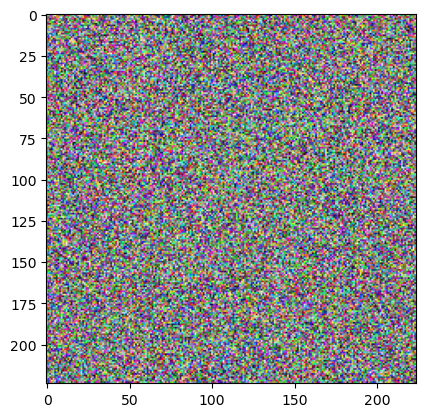

In [11]:
input_tensor_img = input_tensor[0].detach().permute(1,2,0)
plt.imshow(input_tensor_img, cmap="gray")

In [20]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Conclusion:

The results showed that the transferred learning model was not learning the location in frame images that drives the prediction of valence. It suggested that valence might be driven more by the semantic content, rather than the specific arrangment of an image. 
There are multiple limitations in the current version:

1) The frame that is used to predict the valence rating of a video might not be representative to the video. It was chosen at a random time point of the video.

2) Currently, this is done separately on one participant at a time. I haven't figured out an appropriate way to concatenate across multiple participants, which essentially is asking whether we want to make the assumption that everyone extracts the information from an image the same way to make their valence ratings? The original idea was that maybe people have different profiles on how they sample the image spatially to make decisions about valence. But this (at least the first pass on this) says people don't even rely on spatial arrangement. 


